In [1]:
!python -V

Python 3.12.7


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.feature_extraction import DictVectorizer

In [3]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import root_mean_squared_error

In [4]:
import mlflow

mlflow.set_tracking_uri("./mlruns")       #where to save tracking info (local path)
mlflow.set_experiment("first_experiment") #setting the experiment name. Will be created if not already available

<Experiment: artifact_location='/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/02-experiment-tracking/mlruns/670211409295728485', creation_time=1740620213438, experiment_id='670211409295728485', last_update_time=1740620213438, lifecycle_stage='active', name='first_experiment', tags={}>

In [5]:
df=pd.read_parquet('./data/green_tripdata_2021-01.parquet')
print(df.shape)
df.head()

(76518, 20)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [7]:
display(df.trip_type.value_counts())
print('-'*40)
display(df.trip_type.value_counts(normalize=True))

trip_type
1.0    39233
2.0     1238
Name: count, dtype: int64

----------------------------------------


trip_type
1.0    0.96941
2.0    0.03059
Name: proportion, dtype: float64

In [8]:
#getting trip duration
df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
df.duration=df.duration.apply(lambda td: td.total_seconds()/60)

In [9]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [10]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [11]:
#getting ride pct with certain filter
((df.duration>=1) & (df.duration<=60)).mean()

np.float64(0.9658903787344154)

- 96.5% rides are in this filter

In [12]:
df=df[((df.duration>=1) & (df.duration<=60))]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


### Experiment 1

In [13]:
categorical=['PULocationID','DOLocationID']
numerical=['trip_distance']

In [14]:
df[categorical]=df[categorical].astype(str)  #converting to string

In [15]:
train_dict=df[categorical+numerical].to_dict(orient='records')
train_dict[:10]

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [16]:
dv=DictVectorizer()
X_train= dv.fit_transform(train_dict)

In [17]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 221724 stored elements and shape (73908, 507)>

In [18]:
dv.feature_names_ #after OHE (One Hot Encoding)

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [19]:
target='duration'
y_train=df[target].values
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ], shape=(73908,))

In [20]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [21]:
y_pred=lr.predict(X_train)

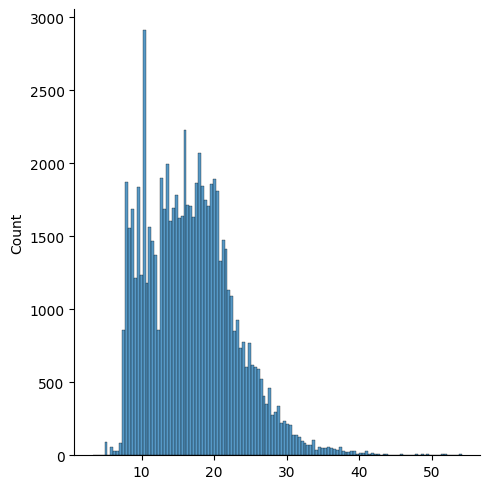

In [22]:
sns.displot(y_pred,label='prediction')


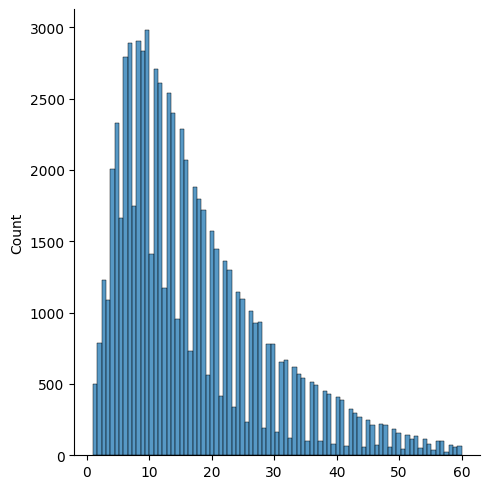

In [23]:
sns.displot(y_train,label='actual')


In [25]:
root_mean_squared_error(y_train,y_pred) #calculate RMSE

9.827368941909366

In [26]:
def read_dataframe(filename):
    df=pd.read_parquet(filename)

    #getting trip duration
    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda td: td.total_seconds()/60)

    #filtering
    df=df[((df.duration>=1) & (df.duration<=60))]

    categorical=['PULocationID','DOLocationID']
    numerical=['trip_distance']

    df[categorical]=df[categorical].astype(str)  #converting to string

    return df

In [27]:
df_train=read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val=read_dataframe('./data/green_tripdata_2021-02.parquet')
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [28]:
len(df_train),len(df_val)

(73908, 61921)

In [29]:
dv=DictVectorizer()

train_dict=df_train[categorical+numerical].to_dict(orient='records')
X_train= dv.fit_transform(train_dict)

val_dict=df_val[categorical+numerical].to_dict(orient='records')
X_val= dv.transform(val_dict)


target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [30]:

lr=LinearRegression()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)


root_mean_squared_error(y_val,y_pred) #calculate RMSE

10.496651120494061

In [31]:
lr=Lasso()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)

root_mean_squared_error(y_val,y_pred) #calculate RMSE

12.212583224318818

In [ ]:
#model tracking with MLFlow
with mlflow.start_run():
    mlflow.set_tag("developer","mahmud")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")


    # alpha_var=0.01
    # alpha_var=0.001
    alpha_var=0.1
    mlflow.log_param("alpha",alpha_var)

    lr=Lasso(alpha=alpha_var)
    lr.fit(X_train,y_train)

    y_pred=lr.predict(X_val)

    rmse=root_mean_squared_error(y_val,y_pred) #calculate RMSE
    mlflow.log_metric("rmse",rmse)

#### Hyper parameter Tuning

In [32]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope 


In [33]:
train=xgb.DMatrix(X_train,label=y_train)
valid=xgb.DMatrix(X_val,label=y_val)

In [34]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster=xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds=50
        )

        y_pred=booster.predict(valid)
        rmse=root_mean_squared_error(y_val,y_pred)
        mlflow.log_metric("rmse",rmse)

    return {'loss':rmse, 'status':STATUS_OK}

In [60]:
search_space={
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1))   #hp.quniform(label, low, high, q); round(uniform(low, high) / q) * q
    , 'learning_rate': hp.loguniform('learning_rate',-3,0)  #hp.loguniform(label, low, high); [exp(low), exp(high)]; exp(-3),exp(0) --> [0.05,1]
    , 'reg_alpha': hp.loguniform('reg_alpha',-5,-1)  #exp(-5),exp(-1) --> [0.007,0.368]
    , 'reg_lambda': hp.loguniform('reg_lambda',-6,-1)   #exp(-6),exp(-1) --> [0.002,0.368]
    , 'min_child_weight': hp.loguniform('min_child_weight',-1,3) #exp(-1),exp(3) --> [0.368,20]
    , 'objective': 'reg:linear'
    , 'seed': 42
}

best_result=fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:9.25272                           
[1]	validation-rmse:7.74548                           
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.00899                           
[3]	validation-rmse:6.66475                           
[4]	validation-rmse:6.50965                           
[5]	validation-rmse:6.44446                           
[6]	validation-rmse:6.41245                           
[7]	validation-rmse:6.39933                           
[8]	validation-rmse:6.39481                           
[9]	validation-rmse:6.39798                           
[10]	validation-rmse:6.40075                          
[11]	validation-rmse:6.40608                          
[12]	validation-rmse:6.40929                          
[13]	validation-rmse:6.41192                          
[14]	validation-rmse:6.41468                          
[15]	validation-rmse:6.41977                          
[16]	validation-rmse:6.42704                          
[17]	validation-rmse:6.43417                          
[18]	validation-rmse:6.43729                          
[19]	validation-rmse:6.44255                          
[20]	valid

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:7.14752                                                    
[7]	validation-rmse:6.94089                                                    
[8]	validation-rmse:6.78889                                                    
[9]	validation-rmse:6.67200                                                    
[10]	validation-rmse:6.58525                                                   
[11]	validation-rmse:6.51895                                                   
[12]	validation-rmse:6.46622                                                   
[13]	validation-rmse:6.42574                                                   
[14]	validation-rmse:6.39306                                                   
[15]	validation-rmse:6.36593                                                   
[16]	validation-rmse:6.34450                                                   
[17]	validation-rmse:6.32503                                                   
[18]	validation-rmse:6.30907            

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:6.41617                                                    
[15]	validation-rmse:6.40040                                                    
[16]	validation-rmse:6.38823                                                    
[17]	validation-rmse:6.38084                                                    
[18]	validation-rmse:6.37177                                                    
[19]	validation-rmse:6.36458                                                    
[20]	validation-rmse:6.35465                                                    
[21]	validation-rmse:6.34805                                                    
[22]	validation-rmse:6.34442                                                    
[23]	validation-rmse:6.34236                                                    
[24]	validation-rmse:6.33728                                                    
[25]	validation-rmse:6.33365                                                    
[26]	validation-rmse:6.32588

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.47791                                                     
[6]	validation-rmse:6.42239                                                     
[7]	validation-rmse:6.38337                                                     
[8]	validation-rmse:6.35778                                                     
[9]	validation-rmse:6.34153                                                     
[10]	validation-rmse:6.32817                                                    
[11]	validation-rmse:6.31671                                                    
[12]	validation-rmse:6.30701                                                    
[13]	validation-rmse:6.30344                                                    
[14]	validation-rmse:6.29873                                                    
[15]	validation-rmse:6.29144                                                    
[16]	validation-rmse:6.29157                                                    
[17]	validation-rmse:6.29139

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.63708                                                     
[6]	validation-rmse:6.65563                                                     
[7]	validation-rmse:6.67014                                                     
[8]	validation-rmse:6.67946                                                     
[9]	validation-rmse:6.69943                                                     
[10]	validation-rmse:6.71770                                                    
[11]	validation-rmse:6.72984                                                    
[12]	validation-rmse:6.75289                                                    
[13]	validation-rmse:6.76719                                                    
[14]	validation-rmse:6.77183                                                    
[15]	validation-rmse:6.77804                                                    
[16]	validation-rmse:6.78246                                                    
[17]	validation-rmse:6.80510

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.35476                                                     
[6]	validation-rmse:6.36224                                                     
[7]	validation-rmse:6.36341                                                     
[8]	validation-rmse:6.36303                                                     
[9]	validation-rmse:6.37736                                                     
[10]	validation-rmse:6.38151                                                    
[11]	validation-rmse:6.38699                                                    
[12]	validation-rmse:6.39710                                                    
[13]	validation-rmse:6.41032                                                    
[14]	validation-rmse:6.41615                                                    
[15]	validation-rmse:6.41917                                                    
[16]	validation-rmse:6.42285                                                    
[17]	validation-rmse:6.42944

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74875                                                    
[1]	validation-rmse:11.31904                                                    
[2]	validation-rmse:10.92126                                                    
[3]	validation-rmse:10.55178                                                    
[4]	validation-rmse:10.21256                                                    
[5]	validation-rmse:9.89880                                                     
[6]	validation-rmse:9.60836                                                     
[7]	validation-rmse:9.34129                                                     
[8]	validation-rmse:9.09640                                                     
[9]	validation-rmse:8.87099                                                     
[10]	validation-rmse:8.66194                                                    
[11]	validation-rmse:8.47269                                                    
[12]	validation-rmse:8.29884

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.80122                                                     
[3]	validation-rmse:6.58128                                                     
[4]	validation-rmse:6.48928                                                     
[5]	validation-rmse:6.45952                                                     
[6]	validation-rmse:6.44054                                                     
[7]	validation-rmse:6.44385                                                     
[8]	validation-rmse:6.44239                                                     
[9]	validation-rmse:6.44361                                                     
[10]	validation-rmse:6.44908                                                    
[11]	validation-rmse:6.45748                                                    
[12]	validation-rmse:6.46325                                                    
[13]	validation-rmse:6.46718                                                    
[14]	validation-rmse:6.47156

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.32872                                                     
[6]	validation-rmse:6.29146                                                     
[7]	validation-rmse:6.27046                                                     
[8]	validation-rmse:6.25225                                                     
[9]	validation-rmse:6.24457                                                     
[10]	validation-rmse:6.23977                                                    
[11]	validation-rmse:6.23696                                                    
[12]	validation-rmse:6.23485                                                    
[13]	validation-rmse:6.23237                                                    
[14]	validation-rmse:6.23373                                                    
[15]	validation-rmse:6.23292                                                    
[16]	validation-rmse:6.22987                                                    
[17]	validation-rmse:6.23170

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.41413                                                     
[9]	validation-rmse:6.37951                                                     
[10]	validation-rmse:6.35425                                                    
[11]	validation-rmse:6.33166                                                    
[12]	validation-rmse:6.31617                                                    
[13]	validation-rmse:6.30156                                                    
[14]	validation-rmse:6.29131                                                    
[15]	validation-rmse:6.28423                                                    
[16]	validation-rmse:6.27786                                                    
[17]	validation-rmse:6.27122                                                    
[18]	validation-rmse:6.26324                                                    
[19]	validation-rmse:6.26005                                                    
[20]	validation-rmse:6.25613

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.55971                                                      
[7]	validation-rmse:6.47929                                                      
[8]	validation-rmse:6.42641                                                      
[9]	validation-rmse:6.38529                                                      
[10]	validation-rmse:6.35530                                                     
[11]	validation-rmse:6.33635                                                     
[12]	validation-rmse:6.31739                                                     
[13]	validation-rmse:6.30737                                                     
[14]	validation-rmse:6.29690                                                     
[15]	validation-rmse:6.28760                                                     
[16]	validation-rmse:6.28090                                                     
[17]	validation-rmse:6.27534                                                     
[18]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:8.44349                                                      
[6]	validation-rmse:8.10622                                                      
[7]	validation-rmse:7.82083                                                      
[8]	validation-rmse:7.58027                                                      
[9]	validation-rmse:7.38263                                                      
[10]	validation-rmse:7.21876                                                     
[11]	validation-rmse:7.08042                                                     
[12]	validation-rmse:6.96408                                                     
[13]	validation-rmse:6.86883                                                     
[14]	validation-rmse:6.78557                                                     
[15]	validation-rmse:6.71831                                                     
[16]	validation-rmse:6.66113                                                     
[17]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.08098                                                     
[2]	validation-rmse:10.59346                                                     
[3]	validation-rmse:10.15171                                                     
[4]	validation-rmse:9.75403                                                      
[5]	validation-rmse:9.39356                                                      
[6]	validation-rmse:9.06839                                                      
[7]	validation-rmse:8.77572                                                      
[8]	validation-rmse:8.51450                                                      
[9]	validation-rmse:8.27807                                                      
[10]	validation-rmse:8.06737                                                     
[11]	validation-rmse:7.88010                                                     
[12]	validation-rmse:7.71395                                                     
[13]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:10.25069                                                     
[5]	validation-rmse:9.93743                                                      
[6]	validation-rmse:9.64806                                                      
[7]	validation-rmse:9.37914                                                      
[8]	validation-rmse:9.13153                                                      
[9]	validation-rmse:8.90185                                                      
[10]	validation-rmse:8.69028                                                     
[11]	validation-rmse:8.49480                                                     
[12]	validation-rmse:8.31552                                                     
[13]	validation-rmse:8.14981                                                     
[14]	validation-rmse:7.99760                                                     
[15]	validation-rmse:7.85762                                                     
[16]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.90508                                                      
[2]	validation-rmse:7.13058                                                      
[3]	validation-rmse:6.75027                                                      
[4]	validation-rmse:6.56319                                                      
[5]	validation-rmse:6.47788                                                      
[6]	validation-rmse:6.43446                                                      
[7]	validation-rmse:6.41222                                                      
[8]	validation-rmse:6.39696                                                      
[9]	validation-rmse:6.39218                                                      
[10]	validation-rmse:6.39108                                                     
[11]	validation-rmse:6.38994                                                     
[12]	validation-rmse:6.39034                                                     
[13]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.81086                                                      
[2]	validation-rmse:7.91678                                                      
[3]	validation-rmse:7.34427                                                      
[4]	validation-rmse:6.97779                                                      
[5]	validation-rmse:6.75576                                                      
[6]	validation-rmse:6.62235                                                      
[7]	validation-rmse:6.53993                                                      
[8]	validation-rmse:6.48838                                                      
[9]	validation-rmse:6.46264                                                      
[10]	validation-rmse:6.44532                                                     
[11]	validation-rmse:6.43204                                                     
[12]	validation-rmse:6.42484                                                     
[13]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.29244                                                      
[9]	validation-rmse:6.28285                                                      
[10]	validation-rmse:6.27623                                                     
[11]	validation-rmse:6.27342                                                     
[12]	validation-rmse:6.26993                                                     
[13]	validation-rmse:6.27806                                                     
[14]	validation-rmse:6.28069                                                     
[15]	validation-rmse:6.28223                                                     
[16]	validation-rmse:6.27676                                                     
[17]	validation-rmse:6.28291                                                     
[18]	validation-rmse:6.28721                                                     
[19]	validation-rmse:6.29314                                                     
[20]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[17]	validation-rmse:6.36114                                                     
[18]	validation-rmse:6.35706                                                     
[19]	validation-rmse:6.35525                                                     
[20]	validation-rmse:6.35531                                                     
[21]	validation-rmse:6.35353                                                     
[22]	validation-rmse:6.35287                                                     
[23]	validation-rmse:6.34729                                                     
[24]	validation-rmse:6.34936                                                     
[25]	validation-rmse:6.35116                                                     
[26]	validation-rmse:6.35106                                                     
[27]	validation-rmse:6.35125                                                     
[28]	validation-rmse:6.35219                                                     
[29]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:6.62670                                                     
[30]	validation-rmse:6.61535                                                     
[31]	validation-rmse:6.60835                                                     
[32]	validation-rmse:6.59832                                                     
[33]	validation-rmse:6.59114                                                     
[34]	validation-rmse:6.58417                                                     
[35]	validation-rmse:6.57716                                                     
[36]	validation-rmse:6.56963                                                     
[37]	validation-rmse:6.56324                                                     
[38]	validation-rmse:6.55849                                                     
[39]	validation-rmse:6.55477                                                     
[40]	validation-rmse:6.55134                                                     
[41]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[26]	validation-rmse:6.62488                                                    
[27]	validation-rmse:6.61696                                                    
[28]	validation-rmse:6.60874                                                    
[29]	validation-rmse:6.60218                                                    
[30]	validation-rmse:6.59576                                                    
[31]	validation-rmse:6.58971                                                    
[32]	validation-rmse:6.58370                                                    
[33]	validation-rmse:6.57671                                                    
[34]	validation-rmse:6.57233                                                    
[35]	validation-rmse:6.56611                                                    
[36]	validation-rmse:6.56266                                                    
[37]	validation-rmse:6.55891                                                    
[38]	validation-rmse:6.55555

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:6.62962                                                     
[22]	validation-rmse:6.61738                                                     
[23]	validation-rmse:6.60766                                                     
[24]	validation-rmse:6.59449                                                     
[25]	validation-rmse:6.58522                                                     
[26]	validation-rmse:6.57439                                                     
[27]	validation-rmse:6.56701                                                     
[28]	validation-rmse:6.56030                                                     
[29]	validation-rmse:6.55243                                                     
[30]	validation-rmse:6.54583                                                     
[31]	validation-rmse:6.54165                                                     
[32]	validation-rmse:6.53471                                                     
[33]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:6.68841                                                     
[32]	validation-rmse:6.68360                                                     
[33]	validation-rmse:6.67883                                                     
[34]	validation-rmse:6.67235                                                     
[35]	validation-rmse:6.66821                                                     
[36]	validation-rmse:6.66154                                                     
[37]	validation-rmse:6.65518                                                     
[38]	validation-rmse:6.65111                                                     
[39]	validation-rmse:6.64786                                                     
[40]	validation-rmse:6.64402                                                     
[41]	validation-rmse:6.64180                                                     
[42]	validation-rmse:6.63762                                                     
[43]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:6.81823                                                     
[30]	validation-rmse:6.80696                                                     
[31]	validation-rmse:6.79763                                                     
[32]	validation-rmse:6.78766                                                     
[33]	validation-rmse:6.78092                                                     
[34]	validation-rmse:6.77130                                                     
[35]	validation-rmse:6.76436                                                     
[36]	validation-rmse:6.75817                                                     
[37]	validation-rmse:6.75130                                                     
[38]	validation-rmse:6.74579                                                     
[39]	validation-rmse:6.74060                                                     
[40]	validation-rmse:6.73445                                                     
[41]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[16]	validation-rmse:6.56977                                                     
[17]	validation-rmse:6.54745                                                     
[18]	validation-rmse:6.52647                                                     
[19]	validation-rmse:6.51139                                                     
[20]	validation-rmse:6.49680                                                     
[21]	validation-rmse:6.48523                                                     
[22]	validation-rmse:6.47555                                                     
[23]	validation-rmse:6.46469                                                     
[24]	validation-rmse:6.45496                                                     
[25]	validation-rmse:6.44920                                                     
[26]	validation-rmse:6.43976                                                     
[27]	validation-rmse:6.43569                                                     
[28]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:9.16936                                                      
[6]	validation-rmse:8.83545                                                      
[7]	validation-rmse:8.53649                                                      
[8]	validation-rmse:8.27449                                                      
[9]	validation-rmse:8.04209                                                      
[10]	validation-rmse:7.83625                                                     
[11]	validation-rmse:7.65612                                                     
[12]	validation-rmse:7.49644                                                     
[13]	validation-rmse:7.35444                                                     
[14]	validation-rmse:7.23079                                                     
[15]	validation-rmse:7.12140                                                     
[16]	validation-rmse:7.02494                                                     
[17]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.49047                                                      
[3]	validation-rmse:8.87591                                                      
[4]	validation-rmse:8.37497                                                      
[5]	validation-rmse:7.96967                                                      
[6]	validation-rmse:7.63959                                                      
[7]	validation-rmse:7.37317                                                      
[8]	validation-rmse:7.16379                                                      
[9]	validation-rmse:6.99209                                                      
[10]	validation-rmse:6.85748                                                     
[11]	validation-rmse:6.75013                                                     
[12]	validation-rmse:6.66427                                                     
[13]	validation-rmse:6.59594                                                     
[14]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.94569                                                      
[7]	validation-rmse:6.78129                                                      
[8]	validation-rmse:6.66364                                                      
[9]	validation-rmse:6.57582                                                      
[10]	validation-rmse:6.50992                                                     
[11]	validation-rmse:6.45863                                                     
[12]	validation-rmse:6.42129                                                     
[13]	validation-rmse:6.39015                                                     
[14]	validation-rmse:6.36657                                                     
[15]	validation-rmse:6.34586                                                     
[16]	validation-rmse:6.32994                                                     
[17]	validation-rmse:6.31713                                                     
[18]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[11]	validation-rmse:8.07538                                                     
[12]	validation-rmse:7.90800                                                     
[13]	validation-rmse:7.75728                                                     
[14]	validation-rmse:7.62335                                                     
[15]	validation-rmse:7.50237                                                     
[16]	validation-rmse:7.39354                                                     
[17]	validation-rmse:7.29681                                                     
[18]	validation-rmse:7.21032                                                     
[19]	validation-rmse:7.13192                                                     
[20]	validation-rmse:7.06078                                                     
[21]	validation-rmse:6.99867                                                     
[22]	validation-rmse:6.94169                                                     
[23]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:6.60874                                                     
[20]	validation-rmse:6.59005                                                     
[21]	validation-rmse:6.57224                                                     
[22]	validation-rmse:6.55683                                                     
[23]	validation-rmse:6.54289                                                     
[24]	validation-rmse:6.53093                                                     
[25]	validation-rmse:6.52300                                                     
[26]	validation-rmse:6.51158                                                     
[27]	validation-rmse:6.50204                                                     
[28]	validation-rmse:6.49712                                                     
[29]	validation-rmse:6.48843                                                     
[30]	validation-rmse:6.48187                                                     
[31]	validation-

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.99482                                                     
[7]	validation-rmse:6.82361                                                     
[8]	validation-rmse:6.70083                                                     
[9]	validation-rmse:6.61200                                                     
[10]	validation-rmse:6.54602                                                    
[11]	validation-rmse:6.49564                                                    
[12]	validation-rmse:6.45793                                                    
[13]	validation-rmse:6.42732                                                    
[14]	validation-rmse:6.40299                                                    
[15]	validation-rmse:6.38115                                                    
[16]	validation-rmse:6.36264                                                    
[17]	validation-rmse:6.34808                                                    
[18]	validation-rmse:6.33560

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.07584                                                     
[4]	validation-rmse:8.58610                                                     
[5]	validation-rmse:8.18158                                                     
[6]	validation-rmse:7.85025                                                     
[7]	validation-rmse:7.57308                                                     
[8]	validation-rmse:7.34894                                                     
[9]	validation-rmse:7.16620                                                     
[10]	validation-rmse:7.01581                                                    
[11]	validation-rmse:6.89343                                                    
[12]	validation-rmse:6.79294                                                    
[13]	validation-rmse:6.70958                                                    
[14]	validation-rmse:6.64041                                                    
[15]	validation-rmse:6.58457

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.51924                                                     
[4]	validation-rmse:9.05307                                                     
[5]	validation-rmse:8.64890                                                     
[6]	validation-rmse:8.30261                                                     
[7]	validation-rmse:8.00449                                                     
[8]	validation-rmse:7.75257                                                     
[9]	validation-rmse:7.53548                                                     
[10]	validation-rmse:7.35245                                                    
[11]	validation-rmse:7.19663                                                    
[12]	validation-rmse:7.06317                                                    
[13]	validation-rmse:6.94946                                                    
[14]	validation-rmse:6.85215                                                    
[15]	validation-rmse:6.77080

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:6.81254                                                    
[22]	validation-rmse:6.77450                                                    
[23]	validation-rmse:6.74246                                                    
[24]	validation-rmse:6.71313                                                    
[25]	validation-rmse:6.68735                                                    
[26]	validation-rmse:6.66382                                                    
[27]	validation-rmse:6.64199                                                    
[28]	validation-rmse:6.62298                                                    
[29]	validation-rmse:6.60488                                                    
[30]	validation-rmse:6.58937                                                    
[31]	validation-rmse:6.57549                                                    
[32]	validation-rmse:6.56152                                                    
[33]	validation-rmse:6.54933

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.27677                                                    
[3]	validation-rmse:9.77468                                                     
[4]	validation-rmse:9.33087                                                     
[5]	validation-rmse:8.94138                                                     
[6]	validation-rmse:8.60030                                                     
[7]	validation-rmse:8.30090                                                     
[8]	validation-rmse:8.04043                                                     
[9]	validation-rmse:7.81098                                                     
[10]	validation-rmse:7.61192                                                    
[11]	validation-rmse:7.44063                                                    
[12]	validation-rmse:7.28926                                                    
[13]	validation-rmse:7.15993                                                    
[14]	validation-rmse:7.04807

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[15]	validation-rmse:7.66459                                                    
[16]	validation-rmse:7.55283                                                    
[17]	validation-rmse:7.45271                                                    
[18]	validation-rmse:7.36134                                                    
[19]	validation-rmse:7.27963                                                    
[20]	validation-rmse:7.20493                                                    
[21]	validation-rmse:7.13720                                                    
[22]	validation-rmse:7.07704                                                    
[23]	validation-rmse:7.02270                                                    
[24]	validation-rmse:6.97219                                                    
[25]	validation-rmse:6.92767                                                    
[26]	validation-rmse:6.88735                                                    
[27]	validation-rmse:6.85079

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.02174                                                    
[3]	validation-rmse:10.67670                                                    
[4]	validation-rmse:10.35401                                                    
[5]	validation-rmse:10.05376                                                    
[6]	validation-rmse:9.77411                                                     
[7]	validation-rmse:9.51397                                                     
[8]	validation-rmse:9.27261                                                     
[9]	validation-rmse:9.04787                                                     
[10]	validation-rmse:8.83827                                                    
[11]	validation-rmse:8.64531                                                    
[12]	validation-rmse:8.46578                                                    
[13]	validation-rmse:8.29875                                                    
[14]	validation-rmse:8.14562

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.83574                                                     
[3]	validation-rmse:8.18859                                                     
[4]	validation-rmse:7.71121                                                     
[5]	validation-rmse:7.35423                                                     
[6]	validation-rmse:7.08731                                                     
[7]	validation-rmse:6.89636                                                     
[8]	validation-rmse:6.75550                                                     
[9]	validation-rmse:6.65331                                                     
[10]	validation-rmse:6.58277                                                    
[11]	validation-rmse:6.52991                                                    
[12]	validation-rmse:6.49237                                                    
[13]	validation-rmse:6.46654                                                    
[14]	validation-rmse:6.44806

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.81370                                                    
[3]	validation-rmse:10.41780                                                    
[4]	validation-rmse:10.05496                                                    
[5]	validation-rmse:9.72258                                                     
[6]	validation-rmse:9.41637                                                     
[7]	validation-rmse:9.13732                                                     
[8]	validation-rmse:8.88150                                                     
[9]	validation-rmse:8.64825                                                     
[10]	validation-rmse:8.43635                                                    
[11]	validation-rmse:8.24316                                                    
[12]	validation-rmse:8.06837                                                    
[13]	validation-rmse:7.90817                                                    
[14]	validation-rmse:7.76264

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:8.57439                                                     
[8]	validation-rmse:8.31597                                                     
[9]	validation-rmse:8.08772                                                     
[10]	validation-rmse:7.88746                                                    
[11]	validation-rmse:7.70957                                                    
[12]	validation-rmse:7.55219                                                    
[13]	validation-rmse:7.41482                                                    
[14]	validation-rmse:7.29356                                                    
[15]	validation-rmse:7.18740                                                    
[16]	validation-rmse:7.09409                                                    
[17]	validation-rmse:7.01172                                                    
[18]	validation-rmse:6.93739                                                    
[19]	validation-rmse:6.87162

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.32121                                                     
[3]	validation-rmse:6.87664                                                     
[4]	validation-rmse:6.63775                                                     
[5]	validation-rmse:6.51282                                                     
[6]	validation-rmse:6.43784                                                     
[7]	validation-rmse:6.39925                                                     
[8]	validation-rmse:6.37871                                                     
[9]	validation-rmse:6.36848                                                     
[10]	validation-rmse:6.36296                                                    
[11]	validation-rmse:6.36304                                                    
[12]	validation-rmse:6.36285                                                    
[13]	validation-rmse:6.36494                                                    
[14]	validation-rmse:6.36323

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.25595                                                     
[3]	validation-rmse:7.63969                                                     
[4]	validation-rmse:7.22390                                                     
[5]	validation-rmse:6.94741                                                     
[6]	validation-rmse:6.75687                                                     
[7]	validation-rmse:6.63340                                                     
[8]	validation-rmse:6.54720                                                     
[9]	validation-rmse:6.48815                                                     
[10]	validation-rmse:6.44760                                                    
[11]	validation-rmse:6.41603                                                    
[12]	validation-rmse:6.39748                                                    
[13]	validation-rmse:6.38225                                                    
[14]	validation-rmse:6.36981

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:6.67931                                                    
[20]	validation-rmse:6.64987                                                    
[21]	validation-rmse:6.62409                                                    
[22]	validation-rmse:6.60170                                                    
[23]	validation-rmse:6.58141                                                    
[24]	validation-rmse:6.56268                                                    
[25]	validation-rmse:6.54741                                                    
[26]	validation-rmse:6.53483                                                    
[27]	validation-rmse:6.52173                                                    
[28]	validation-rmse:6.50951                                                    
[29]	validation-rmse:6.50116                                                    
[30]	validation-rmse:6.49044                                                    
[31]	validation-rmse:6.48110

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:9.77918                                                     
[6]	validation-rmse:9.47840                                                     
[7]	validation-rmse:9.20343                                                     
[8]	validation-rmse:8.95112                                                     
[9]	validation-rmse:8.72172                                                     
[10]	validation-rmse:8.51152                                                    
[11]	validation-rmse:8.31965                                                    
[12]	validation-rmse:8.14396                                                    
[13]	validation-rmse:7.98344                                                    
[14]	validation-rmse:7.83722                                                    
[15]	validation-rmse:7.70491                                                    
[16]	validation-rmse:7.58406                                                    
[17]	validation-rmse:7.47449

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:6.56478                                                    
[15]	validation-rmse:6.56963                                                    
[16]	validation-rmse:6.57283                                                    
[17]	validation-rmse:6.57714                                                    
[18]	validation-rmse:6.58230                                                    
[19]	validation-rmse:6.58393                                                    
[20]	validation-rmse:6.59659                                                    
[21]	validation-rmse:6.60148                                                    
[22]	validation-rmse:6.60617                                                    
[23]	validation-rmse:6.61116                                                    
[24]	validation-rmse:6.61473                                                    
[25]	validation-rmse:6.61752                                                    
[26]	validation-rmse:6.61827

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.99401                                                     
[7]	validation-rmse:6.81748                                                     
[8]	validation-rmse:6.68766                                                     
[9]	validation-rmse:6.59061                                                     
[10]	validation-rmse:6.51848                                                    
[11]	validation-rmse:6.46649                                                    
[12]	validation-rmse:6.42568                                                    
[13]	validation-rmse:6.39356                                                    
[14]	validation-rmse:6.36591                                                    
[15]	validation-rmse:6.34546                                                    
[16]	validation-rmse:6.33029                                                    
[17]	validation-rmse:6.31578                                                    
[18]	validation-rmse:6.30357

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.00243                                                     
[5]	validation-rmse:6.75544                                                     
[6]	validation-rmse:6.59865                                                     
[7]	validation-rmse:6.49355                                                     
[8]	validation-rmse:6.42589                                                     
[9]	validation-rmse:6.37829                                                     
[10]	validation-rmse:6.34822                                                    
[11]	validation-rmse:6.32648                                                    
[12]	validation-rmse:6.30602                                                    
[13]	validation-rmse:6.29236                                                    
[14]	validation-rmse:6.28200                                                    
[15]	validation-rmse:6.27409                                                    
[16]	validation-rmse:6.26887

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.91705                                                    
[2]	validation-rmse:10.37239                                                    
[3]	validation-rmse:9.88599                                                     
[4]	validation-rmse:9.45572                                                     
[5]	validation-rmse:9.07271                                                     
[6]	validation-rmse:8.73467                                                     
[7]	validation-rmse:8.43559                                                     
[8]	validation-rmse:8.17036                                                     
[9]	validation-rmse:7.94060                                                     
[10]	validation-rmse:7.73667                                                    
[11]	validation-rmse:7.55863                                                    
[12]	validation-rmse:7.40110                                                    
[13]	validation-rmse:7.26463

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.70209                                                     
[3]	validation-rmse:6.49875                                                     
[4]	validation-rmse:6.43792                                                     
[5]	validation-rmse:6.40981                                                     
[6]	validation-rmse:6.40340                                                     
[7]	validation-rmse:6.40130                                                     
[8]	validation-rmse:6.41188                                                     
[9]	validation-rmse:6.41517                                                     
[10]	validation-rmse:6.42181                                                    
[11]	validation-rmse:6.42329                                                    
[12]	validation-rmse:6.42803                                                    
[13]	validation-rmse:6.43862                                                    
[14]	validation-rmse:6.44990

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.72298                                                     
[5]	validation-rmse:6.55530                                                     
[6]	validation-rmse:6.45298                                                     
[7]	validation-rmse:6.38976                                                     
[8]	validation-rmse:6.34967                                                     
[9]	validation-rmse:6.32175                                                     
[10]	validation-rmse:6.30286                                                    
[11]	validation-rmse:6.28926                                                    
[12]	validation-rmse:6.27873                                                    
[13]	validation-rmse:6.27260                                                    
[14]	validation-rmse:6.26438                                                    
[15]	validation-rmse:6.25970                                                    
[16]	validation-rmse:6.25575

/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:7.83971                                                     
[9]	validation-rmse:7.62255                                                     
[10]	validation-rmse:7.43737                                                    
[11]	validation-rmse:7.27949                                                    
[12]	validation-rmse:7.14338                                                    
[13]	validation-rmse:7.02835                                                    
[14]	validation-rmse:6.92975                                                    
[15]	validation-rmse:6.84452                                                    
[16]	validation-rmse:6.77272                                                    
[17]	validation-rmse:6.71106                                                    
[18]	validation-rmse:6.65840                                                    
[19]	validation-rmse:6.61119                                                    
[20]	validation-rmse:6.57047

#### Training with best model

In [35]:
params={
    'reg_lambda': 0.043686516857338105,
    'seed': 42,
    'max_depth': 10,
    'min_child_weight': 1.9015433564483444,
    'learning_rate': 0.08702761673319044,
    'objective': 'reg:linear',
    'reg_alpha': 0.050984431806376004
    }

mlflow.xgboost.autolog()

booster=xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid,"validation")],
    early_stopping_rounds=50
)

2025/02/27 11:35:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a543a927515944798dc5a4637010e8ef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:11.52012
[1]	validation-rmse:10.90529
[2]	validation-rmse:10.36092
[3]	validation-rmse:9.87871
[4]	validation-rmse:9.45621
[5]	validation-rmse:9.08459
[6]	validation-rmse:8.75748
[7]	validation-rmse:8.47247
[8]	validation-rmse:8.22199
[9]	validation-rmse:8.00509
[10]	validation-rmse:7.81590
[11]	validation-rmse:7.65032
[12]	validation-rmse:7.50657
[13]	validation-rmse:7.38343
[14]	validation-rmse:7.27237
[15]	validation-rmse:7.17838
[16]	validation-rmse:7.09635


/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[17]	validation-rmse:7.02345
[18]	validation-rmse:6.96006
[19]	validation-rmse:6.90491
[20]	validation-rmse:6.85680
[21]	validation-rmse:6.81254
[22]	validation-rmse:6.77450
[23]	validation-rmse:6.74246
[24]	validation-rmse:6.71313
[25]	validation-rmse:6.68735
[26]	validation-rmse:6.66382
[27]	validation-rmse:6.64199
[28]	validation-rmse:6.62298
[29]	validation-rmse:6.60488
[30]	validation-rmse:6.58937
[31]	validation-rmse:6.57549
[32]	validation-rmse:6.56152
[33]	validation-rmse:6.54933
[34]	validation-rmse:6.53759
[35]	validation-rmse:6.52754
[36]	validation-rmse:6.51762
[37]	validation-rmse:6.50942
[38]	validation-rmse:6.50265
[39]	validation-rmse:6.49426
[40]	validation-rmse:6.48723
[41]	validation-rmse:6.48131
[42]	validation-rmse:6.47492
[43]	validation-rmse:6.46936
[44]	validation-rmse:6.46388
[45]	validation-rmse:6.45842
[46]	validation-rmse:6.45296
[47]	validation-rmse:6.44690
[48]	validation-rmse:6.44307
[49]	validation-rmse:6.43916
[50]	validation-rmse:6.43389
[51]	validatio

2025/02/27 11:35:07 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/02/27 11:35:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mahmudhasan/Desktop/others/personal_projects/mlops_zoomcamp_solution/env_mlops_zoomcamp_solution/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:35:07] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/02/27 11:35:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
